In [2]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
#reading the data: /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Jeffares/Jeffares 2015 measurements and LTRs.xlsx,
#  sheet 4,
#  starting from row 17
data = pd.read_excel('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Jeffares/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=4, header=16)
strain_clusters = pd.read_excel('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Jeffares/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=1, header=4)
#strain_clusters retain strain name and MCL cluster members
strain_clusters = strain_clusters[['strain name', 'MCL cluster']]

#remove entries where misc.flocculation is NaN
#washing data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/washing_wild_isolates.csv
washing = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/washing_wild_isolates.csv')
#add it to data based on column strain, for missing values say NaN
data = data.merge(washing, on='strain', how='left')

data = data[data['misc.flocculation'].notna()]

strain = data['strain']
flocculation = data['misc.flocculation']
#remove misc.flocculation column
#see if any column has string entries and remove them
for col in data.columns:
    if data[col].dtype == 'O':
        print(col)
        data = data.drop(col,axis=1)

data.head()


/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


strain
shape1.lengthtype.liquid
misc.mating.type
shape1.liquid
shape1.solid


/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,aaconc.alanine,aaconc.arginine,aaconc.asparagine,aaconc.aspartate,aaconc.glutamate,aaconc.glutamine,aaconc.glycine,aaconc.histidine,aaconc.isoleucine,aaconc.leucine,...,wb.Tellurite30.5mM.Efficiency,wb.Tellurite30.5mM.lag,wb.Tellurite30.5mM.Rate,wb.Tunicamycin1.ug.ml.Efficiency,wb.Tunicamycin1.ug.ml.lag,wb.Tunicamycin1.ug.ml.Rate,misc.flocculation,ratio,before_wash,sem
51,16.577087,NaN,2.298385,8.084347,56.211830,22.610135,3.741693,3.368561,0.294460,0.214022,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.099640,49.126173,0.018632
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
53,14.175858,NaN,2.734266,10.484040,46.727914,23.387088,4.747336,3.011437,0.381173,0.237583,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.153725,64.531070,0.035180
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.093506,59.181679,0.045816
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


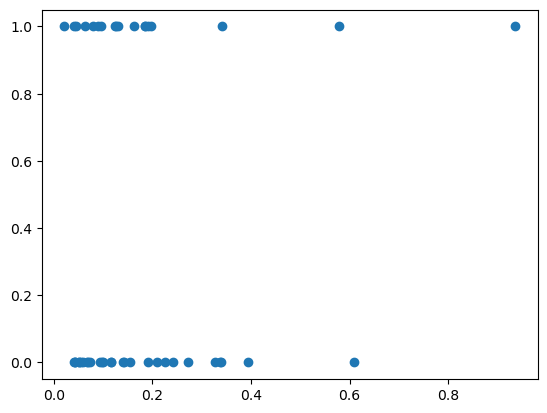

In [3]:
#create a datarame of strain and flocculation, then merge it with washing on column strain
flocculation_df = pd.DataFrame({'strain':strain,'flocculation':flocculation})
flocculation_df= flocculation_df.merge(washing, on='strain')
#remove nans and create scatter plot of  flocculation vs ratio
flocculation_df = flocculation_df[flocculation_df['ratio'].notna()]
plt.scatter(flocculation_df['ratio'],flocculation_df['flocculation'])


In [3]:
#There are multiple different ways to assess significance for each variable.
# Is your coefficient bigger than what would be expected if the data was random?
# -Get the coefficient. Then see how the coefficient changes if you permute the data. Is your original coefficient singnificantly out of this distribution?
# Is your coefficient bigger than 0?
# -Get a confidence interval for the coefficient by bootstrapping. See which quantile 0 is at. Is your coefficient significantly out of this distribution?
# Is your model significant than no model (normal frequency of values)?


In [4]:
#perform logistic regression on all columns to predict misc.flocculation using scikit without splitting the data into training and test sets
from sklearn.linear_model import LogisticRegression
#initialise the model
logreg = LogisticRegression()
#create a dataframe to store the results: columns strain, length of data, score and coefficients
results = pd.DataFrame(columns=['measurement','n_measurement','score','coefficients'])
#for each column subset the data such that there are no NaN values. Then fit the model and print the score. Join dfs using pd.concat
for col in data.columns:
    temp_data = data[col].dropna()
    temp_flocculation = data["misc.flocculation"][temp_data.index]
    logreg.fit(temp_data.values.reshape(-1,1), temp_flocculation)
    #save the score
    score = logreg.score(temp_data.values.reshape(-1,1), temp_flocculation)
    #save the coefficients
    coefficients = logreg.coef_[0]
    #get confidence interval of the coefficients by bootstrapping and see if they are significantly different from 0
    null_coefs = []
    for i in range(10000):
        scrambled_flocculation = np.random.permutation(temp_flocculation)
        logreg.fit(temp_data.values.reshape(-1,1), scrambled_flocculation)
        null_coefs.append(logreg.coef_[0][0])
    p_value = np.sum(np.abs(null_coefs) > np.abs(coefficients))/len(null_coefs)
    temp_results = pd.DataFrame({'measurement': [col],'n_measurement':[len(temp_data)], 'score': score, 'coefficients': coefficients, 'p_value': p_value})
    results = pd.concat([results, temp_results], ignore_index=True)
#correct the p_values by simple bonferroni correction
results['p_value_corrected'] = results['p_value']*len(results)
#sort the results by score
results = results.sort_values(by='p_value_corrected', ascending=True)




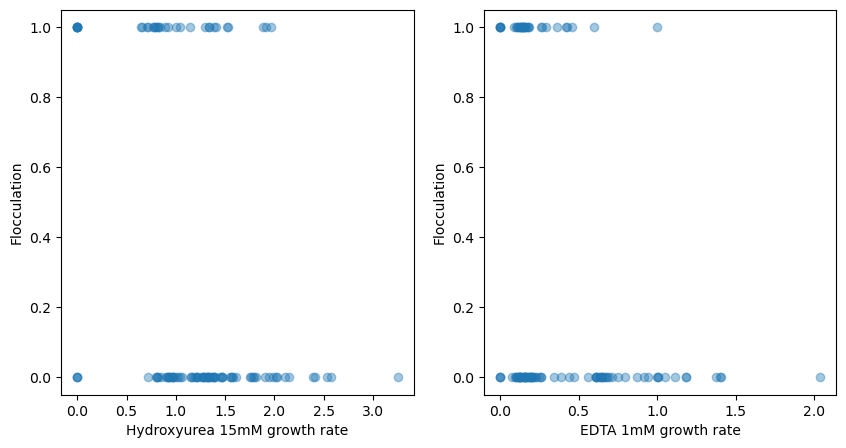

In [5]:
results.head(5)
# plot smgrowth.hydroxyurea.15.mM and smgrowth.EDTA.1.mM against misc.flocculation on two separate subplots with alpha 0.4
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(data['smgrowth.hydroxyurea.15.mM'], data['misc.flocculation'], alpha=0.4)
ax[0].set_xlabel('Hydroxyurea 15mM growth rate')
ax[0].set_ylabel('Flocculation')
ax[1].scatter(data['smgrowth.EDTA.1.mM'], data['misc.flocculation'], alpha=0.4)
ax[1].set_xlabel('EDTA 1mM growth rate')
ax[1].set_ylabel('Flocculation')
plt.show()



In [6]:
#calculate correlation between before_wash and every other column
correlations = data.corrwith(data['before_wash'])

In [8]:
correlations = correlations.sort_values(ascending=False)
correlations

before_wash                    1.000000
smgrowth.sucrose.2percent      0.592107
smgrowth.EMM                   0.578496
smgrowth.maltose.2percent      0.544487
smgrowth.calcofluor.2.ug.ml    0.540057
                                 ...   
smgrowth.MgCl2.0.2.M          -0.465988
smgrowth.CaCl2.150.mM         -0.491017
smgrowth.SDS.0.005percent     -0.503693
ratio                         -0.512058
wb.SrCl225mg.ml.lag                 NaN
Length: 228, dtype: float64

3.150369442793088e-05
6.0360708542117154e-05


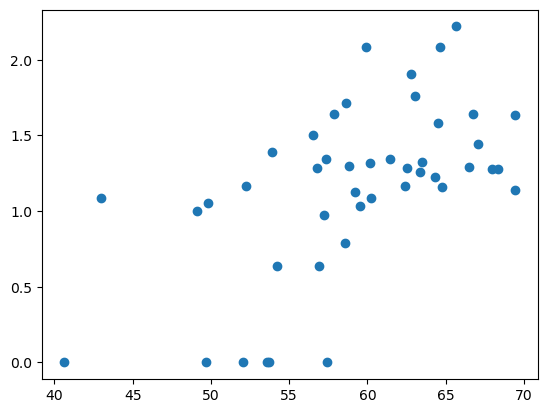

In [16]:
#plot between before_Wash and smgrowth.EMM  
plt.scatter(data['before_wash'], data['smgrowth.EMM'])
#print a p_value
import scipy.stats as st
#eep only values than are not NaN in both arrays
mask = ~np.isnan(data['before_wash']) & ~np.isnan(data['smgrowth.EMM'])
x=data['before_wash'][mask]
y=data['smgrowth.EMM'][mask]

print(st.pearsonr(x,y)[1])
print(st.spearmanr(x,y)[1])


SpearmanrResult(correlation=-0.22535414165666265, pvalue=0.11560160535136982)

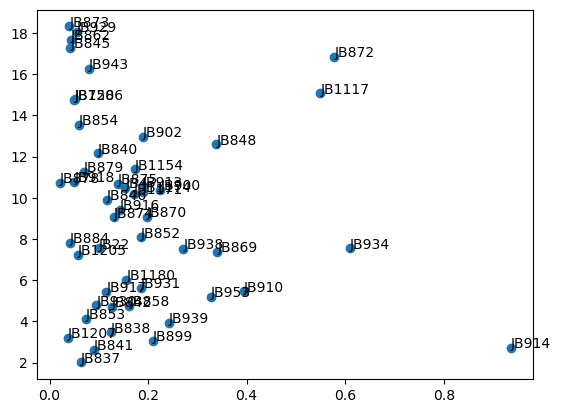

In [18]:
#import Livs phenotype data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Liv_data_mean.csv
liv_data = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Liv_data_mean.csv')
#merge washing and liv_data on Sample = strain
liv_data = liv_data.merge(washing, left_on='Sample', right_on='strain')
#scatter plot of Lifespan and ratio using matplotlib
plt.scatter(liv_data['ratio'],liv_data['Lifespan'])
#label with strain
for i, txt in enumerate(liv_data['Sample']):
    plt.annotate(txt, (liv_data['ratio'][i], liv_data['Lifespan'][i]))
#give me correlation coefficient and p value
#remove nan entries
liv_data = liv_data[liv_data['ratio'].notna()]
liv_data = liv_data[liv_data['Lifespan'].notna()]
#calculate correlation coefficient
np.corrcoef(liv_data['ratio'],liv_data['Lifespan'])
#calculate p value from spearman rank correlation
from scipy.stats import spearmanr
spearmanr(liv_data['ratio'],liv_data['Lifespan'])




In [23]:
#see if there is a sighnificant correlation between ratio and any of the other columns, except Sample and the last 5 columns. Return results in df
def get_correlation(df):
    #initialise df
    results = pd.DataFrame(columns=['measurement','n_measurement','correlation','p_value'])
    #loop through columns
    temp_data_ = df[df['ratio'].notna()]
    for col in df.columns:
        #if the column is numeric
        if df[col].dtype == 'float64':

            if col != 'Sample' and  col != 'strain':
                #remove nan entries
                #keep subset where entries in column "ratio" are not nan
                
   
                temp_data = temp_data_[col].dropna()
                temp_ratio = temp_data_['ratio'][temp_data.index]
                #calculate correlation coefficient
                correlation = np.corrcoef(temp_data,temp_ratio)[0][1]
                #calculate p value
                from scipy.stats import pearsonr
                p_value = pearsonr(temp_data,temp_ratio)[1]
                #save results
                residuals = temp_ratio - correlation*temp_data
                temp_results = pd.DataFrame({'measurement': [col],'n_measurement':[len(temp_data)], 'correlation': correlation, 'p_value': p_value,"residuals": [residuals]})
                results = pd.concat([results, temp_results], ignore_index=True)
                #get a list of residuals and add them to the df
                print(correlation)
                
    #correct the p_values by simple bonferroni correction
    results['p_value_corrected'] = results['p_value']*len(results)
    #sort the results by score
    results = results.sort_values(by='p_value_corrected', ascending=True)
    return results

#see if there is a sighnificant correlation between ratio and any of the other columns, except Sample and the last 5 columns. Return results in df
df = get_correlation(liv_data).head(50)


-0.1486177330961023
-0.5341307455127207
-0.31772863985450434
-0.1470404740154624
-0.10938174280873647
-0.3697646039691448
-0.28208778933693723
-0.6487752866982089
-0.45710381154851626
-0.34673960276920635
-0.6310752048941376
-0.5322221424093123
-0.45483552621070883
-0.5916669516507065
-0.2555177275253551
-0.5833944799309633
-0.46439137645210754
-0.32222140314998826
-0.536834948587831
-0.4297411527051569
-0.47184913583892907
-0.5017868404189799
-0.37061406240533323
-0.21393549410993917
-0.5878030439874127
-0.47953644615042984
-0.35826879461825606
-0.4123371737007394
-0.23249150767126753
-0.5670388793183931
-0.49256889780563523
-0.6154882038570217
-0.40858421167342424
-0.5718166128212072
-0.3940549261705507
-0.37411254148999273
-0.36938918573689966
-0.37866117329895316
-0.16552063662748961
-0.48762758140811285
-0.4440945986911229
-0.2630991844373046
-0.5100007647624881
-0.17009355517373675
-0.25054829429145786
-0.29728029553375507
-0.2297660724235341
-0.3085622249391685
-0.40504436135485

In [ ]:
#measure pairwise correlations between all residuals lists. Return the measurement name of hgihly significant pairs
def get_pairwise_correlation(df):
    #initialise df
    #reset index of df
    df = df.reset_index(drop=True)
    results = pd.DataFrame(columns=['measurement1','measurement2','correlation','p_value'])
    #loop through columns
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            #if the column is numeric
            if df['residuals'][i].dtype == 'float64':
                #remove nan entries
                temp_data1 = df['residuals'][i].dropna()
                temp_data2 = df['residuals'][j].dropna()
                #calculate correlation coefficient
                correlation = np.corrcoef(temp_data1,temp_data2)[0][1]
                #calculate p value
                from scipy.stats import pearsonr
                p_value = pearsonr(temp_data1,temp_data2)[1]
                #save results
                temp_results = pd.DataFrame({'measurement1': [df['measurement'][i]],'measurement2': [df['measurement'][j]],'correlation': correlation, 'p_value': p_value})
                results = pd.concat([results, temp_results], ignore_index=True)
    #correct the p_values by simple bonferroni correction
    results['p_value_corrected'] = results['p_value']*len(results)
    #sort the results by score
    results = results.sort_values(by='p_value_corrected', ascending=True)
    return results
pw_corr = get_pairwise_correlation(df)

In [19]:
# make liv_data_ from liv_data but reomve the last 7 columns
liv_data_ = liv_data.iloc[:,:-2]
#remove column called strain
liv_data_ = liv_data_.drop(columns=['strain'])
liv_data_
#save it to csv
liv_data_.to_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Liv_data_mean_updated.csv')

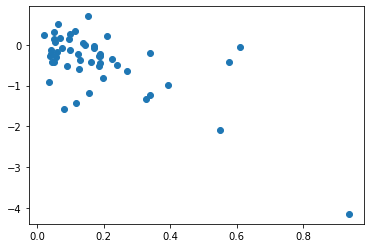

In [ ]:
#plot ratio vs 10mM caffeine using matplotlib
plt.scatter(liv_data['ratio'],liv_data['10mM_caffeine'])


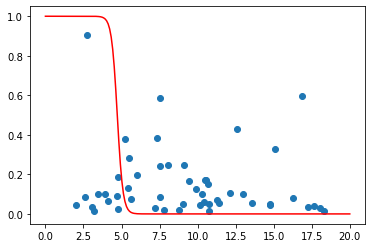

In [ ]:
#fit a logistic curv to the data
from scipy.optimize import curve_fit
def logistic(x, a, b):
    return 1 / (1 + np.exp(-a*(x - b)))
#remove nan entries
liv_data = liv_data[liv_data['ratio'].notna()]
liv_data = liv_data[liv_data['Lifespan'].notna()]
#fit the curve
popt_, pcov = curve_fit(logistic, liv_data['ratio'], liv_data['Lifespan'])
#plot the data
plt.scatter(liv_data['Lifespan'],liv_data['ratio'])
#plot the curve
x = np.linspace(0, 20, 200)
y = logistic(x, *popt_)
plt.plot(x, y, color='red')
plt.show()

(array([5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 7.000e+00, 9.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.310e+02, 2.865e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 1.680e+02, 1.690e+02,
        1.750e+02, 8.290e+02, 3.943e+03, 2.510e+02, 1.210e+02, 1.190e+02,
        1.160e+02, 1.000e+02, 8.900e+01, 7.400e+01, 6.800e+01, 6.500e+01,
        5.200e+01, 4.700e+01, 5.400e+0

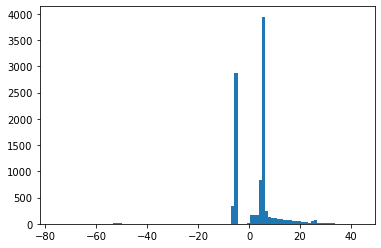

In [ ]:
#histogram of null_coefs 
plt.hist(null_coefs, bins=100)

In [ ]:
np.sum(null_coefs > popt_[0])/len(null_coefs)

0.858

In [ ]:
#scramble the data and see how the first coefficient changes
null_coefs = []
for i in range(10000):
    scrambled_lifespan = np.random.permutation(liv_data['Lifespan'])
    popt, pcov = curve_fit(logistic, liv_data['ratio'], scrambled_lifespan)
    null_coefs.append(popt[0])
#calculate p value
np.sum(null_coefs < popt_[0])/len(null_coefs)



/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.2719

In [ ]:
curve_fit(logistic, liv_data['ratio'], liv_data['Lifespan'])

(array([-5.353605  ,  4.72156582]),
 array([[8.41887845e+15, 5.82570192e+15],
        [5.82570192e+15, 4.65539748e+15]]))

In [24]:
liv_data 
#check correlation between before_wash and other columns
correlations = liv_data.corrwith(liv_data['before_wash'])

In [29]:
correlations.sort_values(ascending=True).head(50)

ratio                                         -0.400441
2percent_Galactose_2percent_Glycerol          -0.342235
sem                                           -0.302974
2percent_Glycerol                             -0.226322
2percent_Galactose                            -0.217405
2percent_Glycerol_2.5g.l_NaAc_20mM_Arginine   -0.195720
2percent_Glycerol_2.5g.l_NaAc                 -0.185034
20mM_Lysine                                   -0.173210
20mM_Serine_20mM_Arginine                     -0.171305
20mM_Aspartate                                -0.170853
20mM_Arginine                                 -0.142245
JB22_7days_exhausted                          -0.137258
20mM_Proline                                  -0.124177
10ug.ml_calcofluor_200mM_MgCl2                -0.123734
10mM_HU_0.0075percent_MMS                     -0.123010
2percent_Glycerol_0.0075percent_MMS           -0.121181
2percent_Fructose                             -0.097694
2percent_EtOH                                 -0